数据来源：
本次实验选取的数据来自B站播放量靠前的关于对“封校”、“大学生封校日常”、“大学生封校精神状态”视频下的评论。
https://www.bilibili.com/video/BV13S4y127YT/?spm_id_from=333.337.search-card.all.click&vd_source=dd5cc72c304ae32d0dc30e29b2abbac7
https://www.bilibili.com/video/BV1RA4y197hF/?spm_id_from=333.337.search-card.all.click
https://www.bilibili.com/video/BV1g34y1Z7nP/?spm_id_from=333.337.search-card.all.click
https://www.bilibili.com/video/BV1jL411A7Yu/?spm_id_from=333.337.search-card.all.click&vd_source=dd5cc72c304ae32d0dc30e29b2abbac7

关于数据清洗：
关于停用词本次实验使用了gtihub上常用的中文停用词表，并在多次实验过程中往表中新增了一些无意义、干扰实验结果的词汇。
去除了评论中的表情及b站常见的表情转文字后的描述

关于实验存在的问题：
数据集不够大
数据的清洗不够完善，还存在一些干扰。
情感倾向分析是借用的百度开源api来实现，没有自己训练模型

爬取数据：
（注意，以下代码爬取的数据已经保存在了以B开头的几个csv文件中，若要自行爬取数据要更换请求头中的“user-Agent”一项为自己B站账号
进行网络请求时的user-Agent。还有一点，以下代码执行过程中如果遇到请求超时的情况会自动中断爬取，而且新爬取的数据会覆盖原有的数据，慎点）

In [ ]:
import requests
import re
import time
import csv

#消息头信息
header = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 SLBrowser/8.0.0.6271 SLBChan/25',
}
#获取评论API
original_url = 'https://api.bilibili.com/x/v2/reply/main?jsonp=jsonp&next={}&type=1&oid={}&mode=3'

#时间戳转换成日期
def get_time(ctime):
    timeArray = time.localtime(ctime)
    otherStyleTime = time.strftime("%Y.%m.%d", timeArray)
    return str(otherStyleTime)

#获取aid
def get_oid(bvid):
    video_url = 'https://www.bilibili.com/video/' + bvid
    page = requests.get(video_url, headers=header).text
    aid = re.search(r'"aid":[0-9]+', page).group()[6:]
    return aid

#边爬取评论边保存文件
def online_save(Bvid):
    all_count = 0
    oid = get_oid(Bvid)
    page = 1
    url = original_url.format(page, oid)
    html = requests.get(url, headers=header)
    data = html.json()
    count = int(data['data']['cursor']['all_count'])
    fname = Bvid + '_评论.csv'
    with open(fname, 'w+', newline='', encoding='utf_8_sig') as f:
        csv_writer=csv.writer(f)
        csv_writer.writerow(["时间", "点赞", "评论"])
        for i in data['data']['replies']:
            message=i['content']['message']
            message = re.sub('\s+', '', message)
            ctime=get_time(i['ctime'])
            like=i['like']
            csv_writer.writerow([ctime,str(like),message])
            all_count = all_count + 1
        print('总评论数：{}，当前评论数:{},爬取Page{}完毕。'.format(count, all_count, page))
        time.sleep(1)
        while all_count < count:
            page += 1
            url = original_url.format(page, oid)
            try:
                html = requests.get(url, headers=header,timeout=20)
                data = html.json()
                for i in data['data']['replies']:
                    message = i['content']['message']
                    ctime = get_time(i['ctime'])
                    like = i['like']
                    csv_writer.writerow([ctime, str(like), message])
                    # f.write(ctime+'\t' + str(like) + '\n')
                    # f.write(message)
                    # f.write('\n------------------------\n')
                    all_count = all_count + 1
                print('总评论数：{}，当前评论数:{},爬取Page{}完毕。'.format(count, all_count, page))
                time.sleep(1)
            except:
                break
        f.close()

if __name__=='__main__':
    Bvid=input('输入视频Bvid:')
    online_save(Bvid)
    print('完成！')

一、导入项目所需的依赖

In [1]:
import pandas as pd
import csv
import jieba
import numpy as np
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
import math
import operator
import codecs
from collections import defaultdict
import jieba.posseg as jp
from gensim import corpora, models

In [6]:
#停用词，这里请在运行了下方声明函数的代码后再来运行
stop_words = readStopWords()
#关键词列表
keywordsstr = ''

二、定义所需函数

In [26]:
# 读取评论数据
def readData(path):
    return pd.read_csv(path)

In [27]:
 # 过滤表情
def filter_emoji(desstr, restr=''):
    try:
        co = re.compile(u'[\U00010000-\U0010ffff]')
    except re.error:
        co = re.compile(u'[\uD800-\uDBFF][\uDC00-\uDFFF]')
    return co.sub(restr, desstr)

下面是把csv文件写进txt文档

In [17]:
# 评论写进评论汇总字典
def writeToDic(dicPath,commentsPath):
    data = readData(commentsPath)
    dic = open(dicPath,mode='w',encoding='utf-8')
    for index in data.index:
        data.loc[index,'评论'] = filter_emoji(data.loc[index,'评论'])
        data.loc[index,'评论'] = re.sub(r'[\[](.*?)[\]]',"",data.loc[index,'评论'])
        dic.write(data.loc[index,'评论']+'\n')
    dic.close()

In [18]:
#读取停用词表
def readStopWords():
    # 停用词
    stopwords = []
    f = open("./stopwords-master/cn_stopwords.txt","r",encoding="utf-8")
    lines = f.readlines()
    for line in lines:
        words = line.split("\n")
        stopwords.append(words[0])
    f.close()
    return stopwords

In [19]:
# 读取文件
def readfile(path):
    fp = open(path, "rb")
    content = fp.read()
    fp.close()
    return content

In [20]:
# 分词
def segment(path):
    text = readfile(path).strip()
    text = text.decode('utf-8')
    text = text.replace("\r\n", "")
    cut_text = " ".join(jieba.cut(text,cut_all=False))
    return cut_text

In [21]:
# 生成词云图
def showWordCloud(cut_text):
    wordcloud = WordCloud(
        font_path="./font/msyh.ttc",
        stopwords = stop_words,
        width=1000,
        height=800
    ).generate(cut_text)
    # plt.imshow(wordcloud,interpolation="biliner")
    # plt.axis("off")
    # plt.show()
    # 保存词云图
    wordcloud.to_file(cut_text + '.png')

In [22]:
#去除停用词
def clear(wordlist,stw):
    newlist = []
    for i in wordlist:
        if(i in stw):
            continue
        else:
            newlist.append(i)
    return newlist

#去除停用词
def clear2(s,stw):
    newStr = ''
    for i in s:
        if(i in stw):
            continue
        else:
            newStr = newStr + i
    return newStr


In [23]:
# 高频词写进词典
def writeWord(dicPath,d):
    data = d
    dic = open(dicPath,mode='wb')
    for index in data.index:        
        print(data.loc[index,'word'])
        dic.write(data.loc[index,'word']+'\n')
    dic.close()

In [24]:
def handleAllContent():
    wordslist=[] #最终词表

    for filename in os.listdir('./data'):
        file_path='./data/'+filename
        file_content=codecs.open(file_path,'r',encoding='utf-8',errors='ignore').read().strip().replace('\n', '').replace(' ', '').replace('\t', '').replace('\r', '')
        # 对每篇文章采用jieba分词（精确模式）
        seg_list=jieba.cut(file_content,cut_all=False) # seg_list是集合类
        # 注意：这里要在for循环里面定义，不然会累加
        seg_list_after = []
        # 对于不是停用词的词，把他加入seg_list_after中
        for seg in seg_list:
            if seg not in stop_words:
                seg_list_after.append(seg)
        #  把列表中的元素以空格连接，返回字符串
        result = ' '.join(seg_list_after)
        wordslist.append(result)
    
    return wordslist

三、将清洗过的数据写入txt文档

In [28]:
writeToDic('./data/评论1.txt','BV1g34y1Z7nP_评论.csv')
writeToDic('./data/评论2.txt','BV1jL411A7Yu_评论.csv')
writeToDic('./data/评论3.txt','BV1RA4y197hF_评论.csv')
writeToDic('./data/评论4.txt','BV13S4y127YT_评论.csv')

四、用词云渲染出4个文档的词云
（生成时去掉了一些停用词，字体越大代表词频越高）

In [29]:
def showWordsCloud(path):
    wordcloud = WordCloud(
        font_path="./font/msyh.ttc",
        stopwords = stop_words,
        width=1000,
        height=800
    ).generate(segment('./data/'+path+'.txt'))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file(path+'.png')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\czy\AppData\Local\Temp\jieba.cache
Loading model cost 1.044 seconds.
Prefix dict has been built successfully.


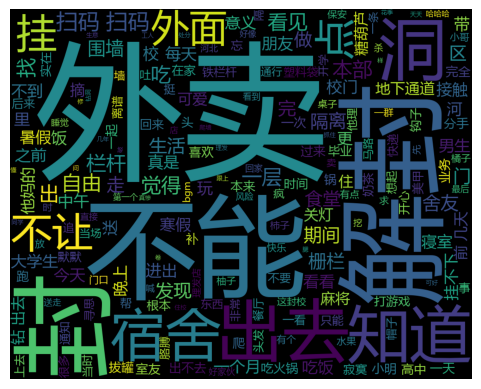

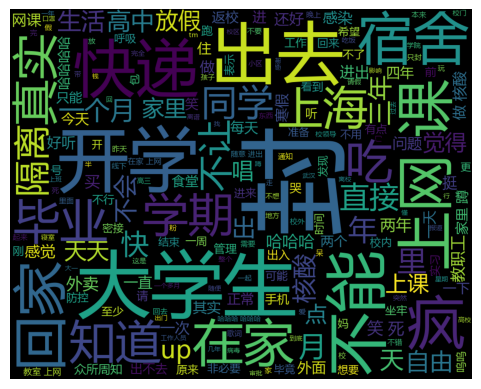

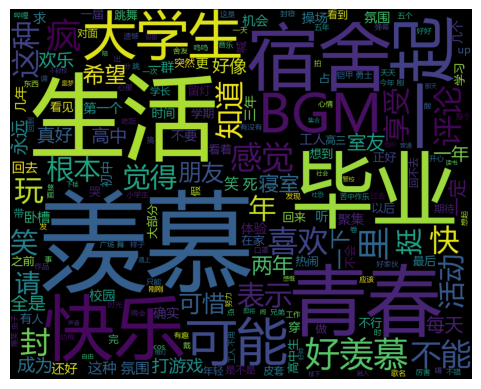

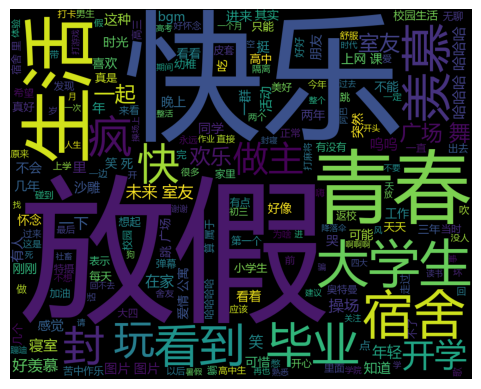

In [13]:
#分别生成四个文档的词云图片
showWordsCloud('评论1')
showWordsCloud('评论2')
showWordsCloud('评论3')
showWordsCloud('评论4')

In [ ]:
通过词云的展现，发现几个视频下的评论出现的高频词汇大同小异。

五、通过tf-idf分析数据的主题词

上述说到通过词云我们可以知道每个视频下对于封校和封校日常等的高频出现词汇，但为了更进一步发掘各视频下评论的其他特征，
于是通过计算各个数据集词汇的tfidf值来区分每个视频对于封校讨论的主题词。

In [16]:
from collections import Counter
corpus = handleAllContent()
#对语料进行分词
word_list = []
for i in range(len(corpus)):
    word_list.append(corpus[i].split(' '))
#统计词频
countlist = []
for i in range(len(word_list)):
    count = Counter(word_list[i])
    countlist.append(count)
countlist
#定义计算tfidf公式的函数
# word可以通过count得到，count可以通过countlist得到

# count[word]可以得到每个单词的词频， sum(count.values())得到整个句子的单词总数
def tf(word, count):
    return count[word] / sum(count.values())

# 统计的是含有该单词的句子数
def n_containing(word, count_list):
    return sum(1 for count in count_list if word in count)
 
# len(count_list)是指句子的总数，n_containing(word, count_list)是指含有该单词的句子的总数，加1是为了防止分母为0
def idf(word, count_list):
    return math.log(len(count_list) / (1 + n_containing(word, count_list)))

# 将tf和idf相乘
def tfidf(word, count, count_list):
    return tf(word, count) * idf(word, count_list)
#计算每个单词的tfidf值
for i, count in enumerate(countlist):
    print("视频 {}".format(i + 1))
    scores = {word: tfidf(word, count, countlist) for word in count}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:5]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

视频 1
	Word: 解封, TF-IDF: 0.00477
	Word: 扫码, TF-IDF: 0.00477
	Word: 一层, TF-IDF: 0.00298
	Word: 本部, TF-IDF: 0.00298
	Word: 接触, TF-IDF: 0.00179
视频 2
	Word: 上网, TF-IDF: 0.00162
	Word: 教职工, TF-IDF: 0.00161
	Word: 核酸, TF-IDF: 0.00117
	Word: 家里, TF-IDF: 0.00106
	Word: 非必要, TF-IDF: 0.00081
视频 3
	Word: 好羡慕, TF-IDF: 0.00151
	Word: 氛围, TF-IDF: 0.00128
	Word: 留灯, TF-IDF: 0.00112
	Word: 享受, TF-IDF: 0.00093
	Word: 五年, TF-IDF: 0.00084
视频 4
	Word: 做主, TF-IDF: 0.00296
	Word: 年轻, TF-IDF: 0.00111
	Word: 好羡慕, TF-IDF: 0.00092
	Word: 走过, TF-IDF: 0.00089
	Word: 乐队, TF-IDF: 0.00089


以上是各个视频前5的tfidf特征，由此我们得到了每个视频的评论区别于其他视频的特征。

六、情感倾向分析

这里借用百度开源的api对评论进行情感倾向分析

In [17]:
# 使用百度api必要的一些准备
import aip
APP_ID = '28539594'
API_KEY = 'WppbomeIAhGXB67PBZpyPqWR'
SECRET_KEY = 'q0mXTF3qGVv2ndLo44LmY8kPTwvczOmH'
nlp = aip.nlp.AipNlp(APP_ID, API_KEY, SECRET_KEY)

In [18]:
# 将所有评论读到列表中
def readDict():
    wordList = []
    for i in range(4):        
        f=open("./data/评论"+str(i+1)+".txt","r",encoding='utf-8')
        lines=f.readlines()
        for line in lines:
            words = line.split("\n")
            wordList.append(words[0])
        f.close()
    return wordList
wordList = readDict()

In [19]:
comments_list = []
for i in wordList:
    comments_list.append({'comments':i})

In [20]:
import time
'''
获取所有的评论信息及评论情感预测信息
'''
def getAllSentiments(comments_list):

    #存放所有评论及情感预测信息的列表
    comment_sentiments = []

    #循环遍历所有评论，并预测评论的情感
    for comment in comments_list:

        #异常处理，防止评论出现特殊字符导致程序异常终止
        try:

            #使用 Baidu AI的NLP自然语言处理接口.进行评论情感分析，并返回分析结果
            sentiment_result = nlp.sentimentClassify(comment['comments'])['items'][0]

            #以下为 sentiment_result 内的参数属性
            # confidence----代表可信度
            # negative_prob----代表消极情绪概率
            # positive_prob----代表积极情绪概率
            # sentiment----代表情绪识别结果，0为消极，1为中性，2为积极

            #封装评论及预测，并添加到预测列表中
            comment_sentiment = {
                'comment': comment['comments'],          #评论内容
                #format()函数统一将 小数数据 转化为 百分比数据
                'positive_prob': format(sentiment_result['positive_prob'], '.2%'),      #情绪积极概率
                'negative_prob': format(sentiment_result['negative_prob'], '.2%'),      #情绪消极概率
                'sentiment': sentiment_result['sentiment'],         #情绪结果
                'confidence': format(sentiment_result['confidence'], '.2%'),        #可信度概率
            }

#             print(comment_sentiment)                #输出分析的数据

            comment_sentiments.append(comment_sentiment)        #添加到情绪列表之中

        except Exception:
            pass

        time.sleep(1)                 #由于百度情绪识别的请求接口存在并发限制，故每1s请求一次

    return comment_sentiments           #返回所有情绪结果


In [21]:
import xlwt
'''
信息保存至Excel表格
'''
def saveExcel(comment_sentiments):

    #Step1: 创建excel表格类型文件，即工作薄对象，编码格式为 utf-8
    workbook = xlwt.Workbook(encoding='utf-8')

    #Step2: 创建工作表对象
    worksheet = workbook.add_sheet('sentiment analysis')

    #Step3: 设置表头信息
    worksheet.write(0, 0, '评论内容')
    worksheet.write(0, 1, '积极概率')
    worksheet.write(0, 2, '消极概率')
    worksheet.write(0, 3, '情绪结果(0消极、1中性、2积极)')
    worksheet.write(0, 4, '可信度')

    #Step4: 将所有的评论情绪信息写入Excel表格之中
    for i in range(len(comment_sentiments)):
        worksheet.write(i+1, 0, comment_sentiments[i]['comment'])
        worksheet.write(i+1, 1, comment_sentiments[i]['positive_prob'])
        worksheet.write(i+1, 2, comment_sentiments[i]['negative_prob'])
        worksheet.write(i+1, 3, comment_sentiments[i]['sentiment'])
        worksheet.write(i+1, 4, comment_sentiments[i]['confidence'])

    #Step5: 保存Excel文件至本地
    workbook.save('./sentiment.xls')

    #打印保存信息
    print('Save Successfully!')



In [398]:
# 这个单元格不要轻易动，不然会跑很久
if __name__ == '__main__':
    
    comment_sentiments = getAllSentiments(comments_list)
    saveExcel(comment_sentiments)

In [22]:
data = pd.read_excel('sentiment.xls')

下面取出了置信度95%以上的评论，对这些评论进行正向方向统计

In [23]:
pd.set_option('display.max_rows',None)
data = data.sort_values(by="可信度", ascending=False)
data = data[data['可信度'].str.strip("%").astype(float)/100 > 0.95]
data = data.drop_duplicates()
# 由于数据太多了，这里只显示前10行看看就好
data.head()

,评论内容,积极概率,消极概率,情绪结果(0消极、1中性、2积极),可信度
76,羡慕,100.00%,0.00%,2,99.99%
49,唱的很好诶！,99.99%,0.01%,2,99.99%
55,笑死，根本根本回不去学校,0.00%,100.00%,0,99.99%
54,真好啊，今年刚毕业,100.00%,0.00%,2,99.99%
53,因为不曾拥有过，所以我很羡慕，所以我笑的很开心，就像我经历过,100.00%,0.00%,2,99.99%


借用饼状图直观看情感倾向分布

In [24]:
# 统计概率
count = data['情绪结果(0消极、1中性、2积极)'].value_counts()
count

2    676
0    606
1      5
Name: 情绪结果(0消极、1中性、2积极), dtype: int64

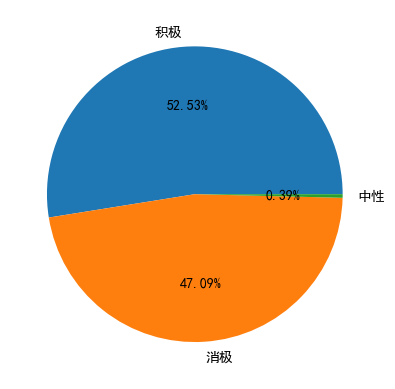

In [25]:
plt.rcParams['font.sans-serif'] = 'simhei'
data = [676,606,5]
label = ['积极', '消极', '中性'] 
plt.pie(data, labels = label, autopct='%.2f%%')
plt.show()

以上饼状图可看出积极和消极倾向基本各占一半，而中性的倾向占比很小，大概可了解到大学生对于封校的讨论情绪比较两极化。

七、结论

在本次实验中，我们爬取了B站平台播放量较高、围绕大学生封校这一主题的多个视频下方的评论来作为实验数据。在实验开始前我们对数据进行了一些
必要的清洗来减少干扰，并通过选取中国停用词表、在实验过程中不断更新此表的方式来增加实验的准确率。

首先我们是通过python中的jieba库和wordCloud库来实现对数据的分词和可视化。wordCloud在让数据可视化的同时也能够清晰的突出数据集的重点，
在词云图中字体越大的词代表出现的频次越高。通过生成的词云图，我们发现对于封校话题的讨论，“解封”、“快递”、“外卖”、“网课”、
“宿舍”、“青春”、“生活”、“羡慕”、“毕业”、“出去”、“疯”等词汇在每个数据集中出现的频率都很高，由此我们能够初步判断在疫情封校
的期间，大学生对此的讨论高度聚焦在解封外出、快递外卖等诉求中，同时也包括了对于“青春”与“生活”的讨论。

接着我们又进一步对评论进行了情感倾向分析。此步骤的实现我们借助了百度开源的api，对每条评论进行分析并得到结果后，我们选取了置信度在95%以上
所有分析结果来统计对于封校讨论的情感倾向。情感倾向的结果分为正向、消极和中性三种，我们得到的结果是正向情感和消极情感基本持平，中性情绪占比极小，由此我们大学生对于封校的讨论情绪比较两极化。

此外我们还通过计算每个评论集中词汇的tfidf值来挖掘各评论集的特征。通过对词汇的tfidf计算，我么发现除了与其他评论集雷同的高频词汇，每个评论集其实都出现了区别于其他评论集的词，其中“教职工”、“解封”、“做主”、“羡慕”等词的tfidf值较高。在我们选取的封校主题的视频中，内容既有
大学生封校期间在校娱乐的方式，也有大学生对封校的吐槽与思考，通过对tfidf值对主题词的提取，能够清楚地展示评论所聚焦的不同主题。